In [1]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (256, 256, 3)

model = build_unet(input_shape)


In [2]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

In [ ]:
pip uninstall tensorflow-datasets

In [34]:
pip install --upgrade --force-reinstall tensorflow_datasets

  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
  Using cached numpy-1.25.2-cp39-cp39-win_amd64.whl (15.6 MB)
  Using cached dm_tree-0.1.8-cp39-cp39-win_amd64.whl (101 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached psutil-5.9.5-cp36-abi3-win_amd64.whl (255 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached etils-1.4.1-py3-none-any.whl (135 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
     ---------------------------------------- 0.0/430.4 kB ? eta -:--:--
      --------------------------------------- 10.2/430.4 kB ? eta -:--:--
      --------------------------------------- 10.2/430.4 kB ? eta -:--:--
      --------------------------------------- 10.2/430.4 kB ? eta -:--:--
      --------------------------------------- 10.2/430.4 kB ? eta -:--:--
      --------------------------------------- 10.2/430.4 kB ? eta -:--:--
      --------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Shivam\\AppData\\Roaming\\Python\\Python39\\site-packages\\~ree\\_tree.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, MeanIoU

from tensorflow.keras import backend as K
import time

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 256
EPOCHS = 10
BATCH = 8






def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    print(y.shape)
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset


train_x_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/train/images"
train_x_file_names = os.listdir(train_x_folder_path)
train_x = [os.path.join(train_x_folder_path, file_name) for file_name in train_x_file_names]
# train_x

train_y_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/train/masks"
train_y_file_names = os.listdir(train_y_folder_path)
train_y = [os.path.join(train_y_folder_path, file_name) for file_name in train_y_file_names]
# train_y




valid_x_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/val/images"
valid_x_file_names = os.listdir(valid_x_folder_path)
valid_x = [os.path.join(valid_x_folder_path, file_name) for file_name in valid_x_file_names]
# valid_x

valid_y_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/val/masks"
valid_y_file_names = os.listdir(valid_y_folder_path)
valid_y = [os.path.join(valid_y_folder_path, file_name) for file_name in valid_y_file_names]
# valid_y




test_x_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/test/images"
test_x_file_names = os.listdir(test_x_folder_path)
test_x = [os.path.join(test_x_folder_path, file_name) for file_name in test_x_file_names]
# test_x

test_y_folder_path = "D:/Development/ML DS DL/Segmentation/archive(1)/GLAS_Indexed_Original/test/masks"
test_y_file_names = os.listdir(test_y_folder_path)
test_y = [os.path.join(test_y_folder_path, file_name) for file_name in test_y_file_names]
# test_y

print("Train_X")
print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

print("Train_Y")
print("Training data: ", len(train_y))
print("Validation data: ", len(valid_y))
print("Testing data: ", len(test_y))

Train_X
Training data:  70
Validation data:  15
Testing data:  80
Train_Y
Training data:  70
Validation data:  15
Testing data:  80


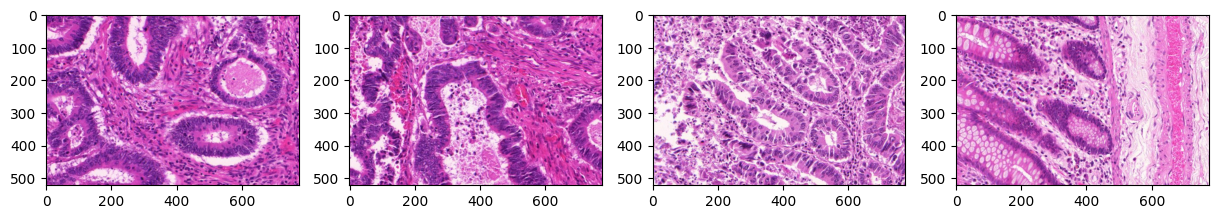

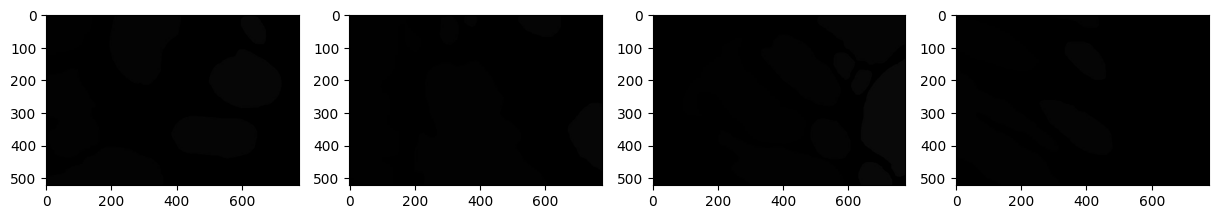

In [5]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [46]:
x = read_image(train_x[1])
y = read_mask(train_y[1])
print("Image shape:", x.shape)
print("Mask shape:", y.shape)


AttributeError: 'str' object has no attribute 'decode'

In [6]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))


def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou_score = intersection / (union + smooth)
    return iou_score

LR = 1e-4
opt = tf.keras.optimizers.legacy.Nadam(LR)
metrics = [dice_coef, recall, precision, f1_score, accuracy, iou, voe_metric, rvd_metric]

(256, 256, 1)
(256, 256, 1)


In [7]:
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

In [8]:
import time


logdir='/kaggle/working/logs'
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_callback2 = tf.keras.callbacks.EarlyStopping(min_delta=0.0010, patience=5, verbose=1, mode='min')

start_time = time.time()
print("For U-Net-2D:")
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch= train_steps,
    validation_steps= valid_steps,
    callbacks=[tensorboard_callback1, tensorboard_callback2]
)
model.save('UNet2D.hdf5')
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken to train the model: ", elapsed_time, "secs")

For U-Net-2D:
Epoch 1/10
9/9 [==============================] - 34s 1s/step - loss: 0.9815 - dice_coef: 0.0186 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.2245 - iou: 0.0094 - voe_metric: 0.9906 - rvd_metric: 60.5660 - val_loss: 0.9797 - val_dice_coef: 0.0203 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4262 - val_iou: 0.0103 - val_voe_metric: 0.9897 - val_rvd_metric: 46.0998
Epoch 2/10
9/9 [==============================] - 3s 345ms/step - loss: 0.9771 - dice_coef: 0.0230 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_score: 0.0000e+00 - accuracy: 0.3272 - iou: 0.0116 - voe_metric: 0.9884 - rvd_metric: 57.1845 - val_loss: 0.9796 - val_dice_coef: 0.0204 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4043 - val_iou: 0.0103 - val_voe_metric: 0.9897 - val_rvd_metric: 46.2979
Epoch 3/10
9/9 [==============================] - 3s 346ms/step - loss: 

C:\Users\Shivam\AppData\Local\Temp\ipykernel_36616\762579878.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


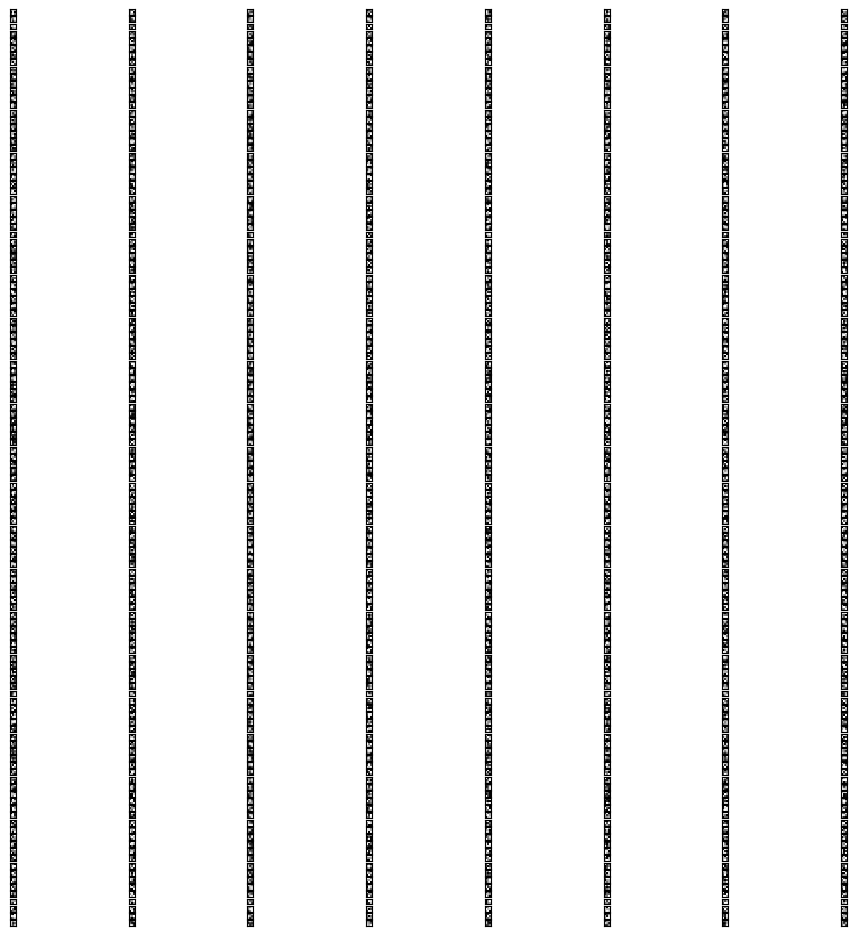

In [62]:
import matplotlib.pyplot as plt

# Assuming you want to visualize the filters in the first convolutional layer (layer index 1)
conv_layer = model.layers[32]

# Get the weights (filters) of the convolutional layer
filters, biases = conv_layer.get_weights()

# Calculate the number of filters in the layer
n_filters = filters.shape[3]

# Define the number of rows and columns for visualization
columns = 8
rows = (n_filters // columns) + 1  # Ensure there are enough rows for all filters

# Create a figure to display the filters
fig = plt.figure(figsize=(12, 12))

# Loop through and plot each filter
for i in range(1, n_filters + 1):
    f = filters[:, :, :, i - 1]

    # Add a subplot for each filter
    ax = fig.add_subplot(rows, columns, i)
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the filter using a grayscale colormap
    ax.imshow(f[:, :, 0], cmap='gray')

# Adjust the layout
plt.tight_layout()

# Show the figure with filters
plt.show()


In [17]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x
def read_mask(path):
    x=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x=cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x=np.expand_dims(x, axis=-1)
    x=x/255.0
    return x

In [22]:
x = read_image(train_x[1])

In [23]:
y = read_mask(train_y[i])

In [9]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['activation_8[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17

1/1 [==============================] - 0s 406ms/step


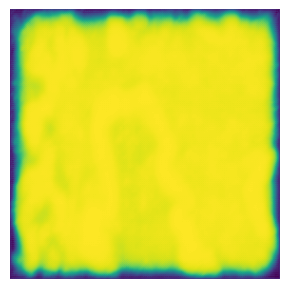

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model

# Assuming `model` is your U-Net model
bottleneck_layer_name = "conv2d_18"  # Replace with the actual layer name

# Create a sub-model that outputs the bottleneck layer's activations
bottleneck_model = Model(inputs=model.input, outputs=model.get_layer(bottleneck_layer_name).output)

# Load a sample input image (adjust as needed)
  # Replace with your input image loading code

# Preprocess the input image (e.g., resizing and normalization) to match the model's input requirements
# You may need to adjust this based on your model's preprocessing steps

# Predict the feature map at the bottleneck layer for the input image
bottleneck_features = bottleneck_model.predict(np.expand_dims(x, axis=0))

# Visualize the feature maps
n_filters = bottleneck_features.shape[-1]  # Number of filters in the bottleneck layer

# Create a grid of subplots to visualize the feature maps
plt.figure(figsize=(16, 20))
for i in range(n_filters):
    plt.subplot(4, 4, i + 1)  # Adjust the subplot layout as needed
    plt.imshow(bottleneck_features[0, :, :, i], cmap='viridis')  # Visualize the i-th feature map
    plt.axis('off')

plt.show()


In [20]:


def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask



    

In [26]:

y_pred3 = model.predict(np.expand_dims(x, axis=0), verbose=0)[0] > 0.5
h, w, _ = x.shape
white_line = np.ones((h, 10, 3))
all_images = [
    x, white_line,
    mask_parse(y), white_line,
    y_pred3]
image = np.concatenate(all_images, axis=1)
fig = plt.figure(figsize=(12, 12))
a = fig.add_subplot(1, 1, 1)
plt.title("Original Image ----------- True Mask ----------- Predicted Mask")
imgplot = plt.imshow(image)
imgplot.set_clim(0.0, 1.4)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 4 has size 1